/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.war

[ 6  5 10  4  1  3  2  7  8  9]
[9.9990940e-01 7.0608497e-05 6.3030388e-06 5.5709270e-06 2.8878280e-06
 2.8049808e-06 1.0112801e-06 6.3059821e-07 5.6060884e-07 1.6979862e-07]
Test Predictions: 코카콜라 1.5l
Identified Classes in Segmentation Mask:
Class 0: background
Class 1: drink
Class 3: Human_hand


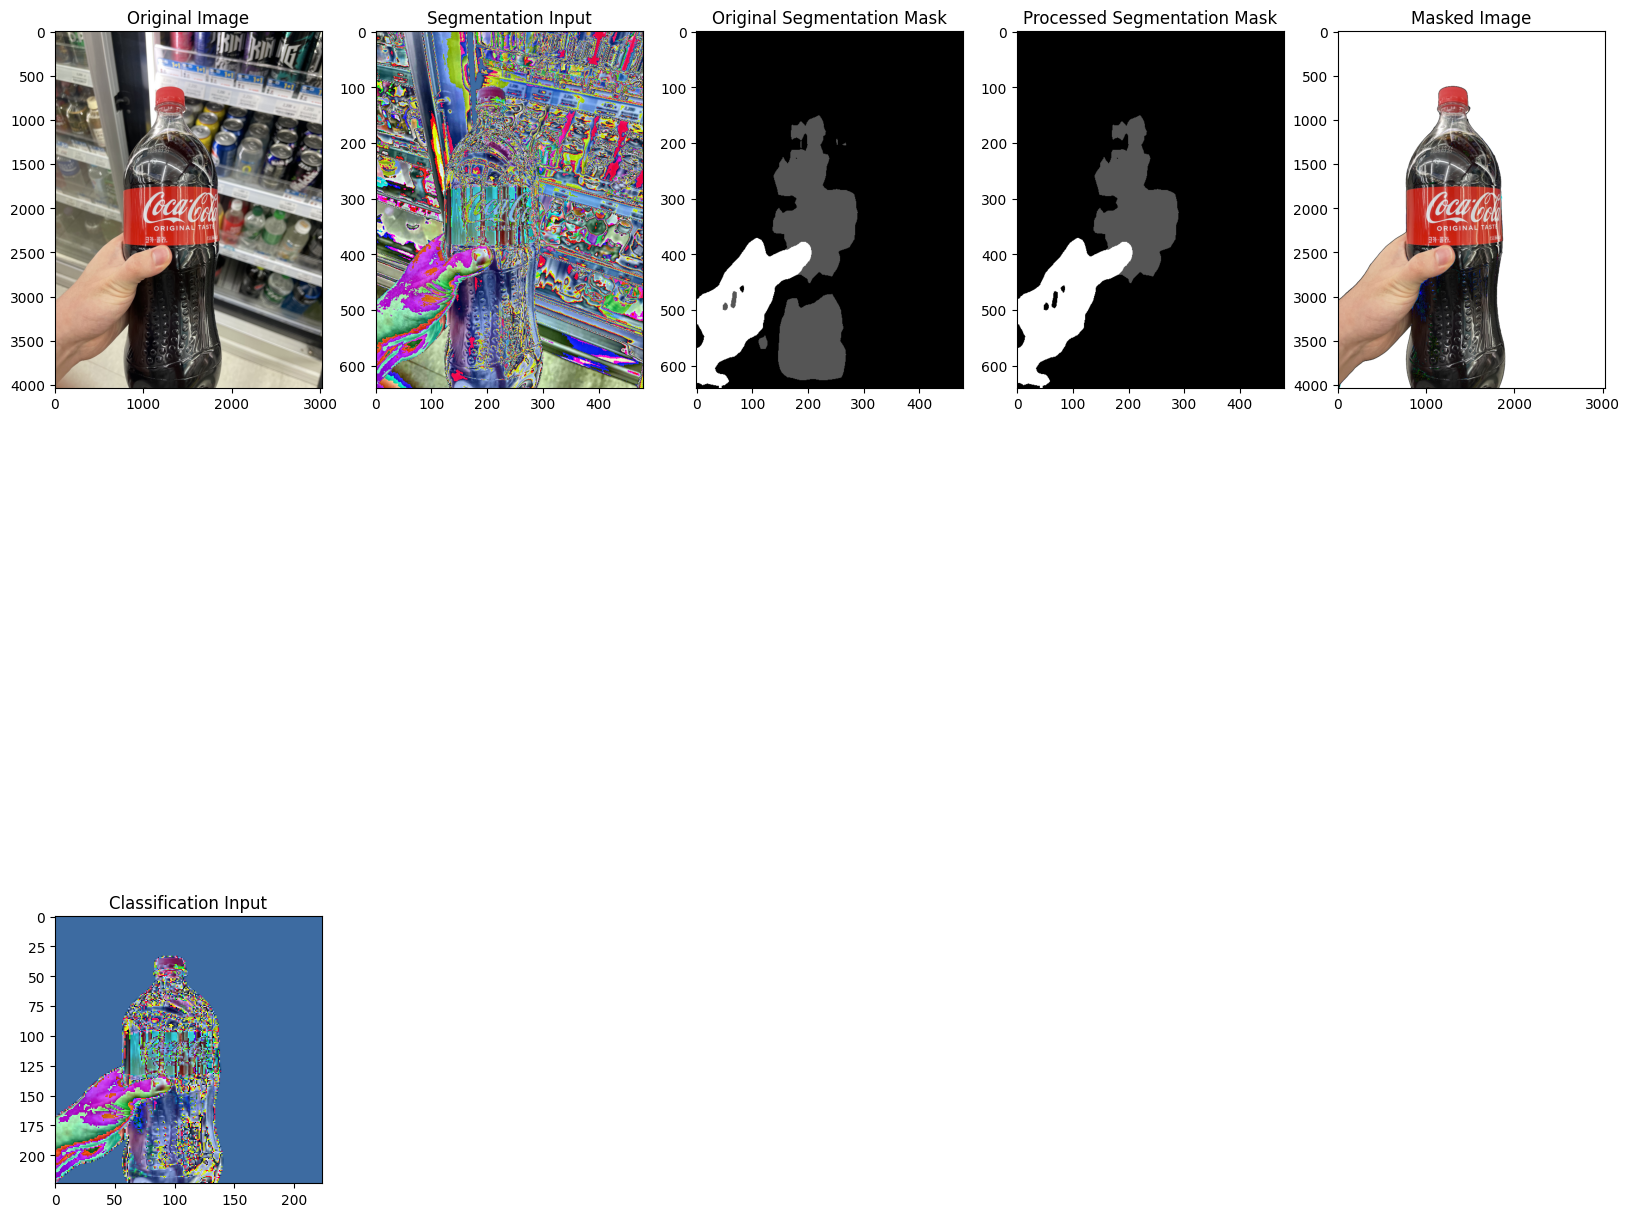

In [10]:
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
from scipy.ndimage import label, binary_fill_holes
import copy
from transformers import pipeline
from PIL import Image, ImageFile
import torch.nn as nn
import torch.nn.functional as F

class CustomImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomImageClassifier, self).__init__()
        self.base_model = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = F.softmax(x, dim=1)

        return x

# 이미지 로드 및 전처리
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((640, 480)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img)
    img_resized = cv2.resize(img, (480, 640))
    img_tensor = img_tensor.unsqueeze(0)  # 배치 차원 추가
    return img, img_tensor, img_resized

# 추론 함수
def predict(model, image_tensor, device):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)['out'][0]
    output_predictions = output.argmax(0)
    return output_predictions.byte().cpu().numpy()

# 더 큰 클래스만 남기고 나머지를 배경으로 전환
def select_largest_class(mask, class1_id, class2_id):
    class1_size = np.sum(mask == class1_id)
    class2_size = np.sum(mask == class2_id)
    if class1_size > class2_size:
        mask[mask == class2_id] = 0  # 작은 클래스는 배경으로 설정
        return class1_id
    else:
        mask[mask == class1_id] = 0  # 작은 클래스는 배경으로 설정
        return class2_id

# 같은 클래스 중 가장 큰 바운딩 박스만 남기기
def select_largest_bbox(mask, class_id):
    labeled_mask, num_labels = label(mask == class_id)
    largest_area = 0
    largest_label = 0
    for i in range(1, num_labels + 1):
        area = np.sum(labeled_mask == i)
        if area > largest_area:
            largest_area = area
            largest_label = i
    mask[mask == class_id] = 0  # 모든 객체를 배경으로 설정
    mask[labeled_mask == largest_label] = class_id  # 가장 큰 바운딩 박스만 남기기
    return mask

# 결과 시각화
def visualize_results(original_img, img_tensor, original_mask, mask, masked_img, classification_img, individual_crops):
    num_crops = len(individual_crops)
    plt.figure(figsize=(20, 20))
    plt.subplot(2, num_crops + 5, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.subplot(2, num_crops + 5, 2)
    plt.title("Segmentation Input")
    plt.imshow(transforms.ToPILImage()(img_tensor.squeeze(0)))
    plt.subplot(2, num_crops + 5, 3)
    plt.title("Original Segmentation Mask")
    plt.imshow(original_mask, cmap='gray')
    plt.subplot(2, num_crops + 5, 4)
    plt.title("Processed Segmentation Mask")
    plt.imshow(mask, cmap='gray')
    if masked_img is not None:
        plt.subplot(2, num_crops + 5, 5)
        plt.title("Masked Image")
        plt.imshow(masked_img)
        plt.imsave('masked.png', masked_img)
    for i, crop in enumerate(individual_crops):
        plt.subplot(2, num_crops + 5, 6 + i)
        plt.title(f"Crop {i + 1}")
        plt.imshow(crop)
        plt.imsave(f'individual_crop_{i + 1}.png', crop)

    if classification_img is not None:
        plt.subplot(2, num_crops + 5, num_crops + 6)
        plt.title("Classification Input")
        plt.imshow(transforms.ToPILImage()(classification_img))
    plt.show()

# 제품 이름 가져오기
def get_product_name(class_id, csv_path):
    df = pd.read_csv(csv_path)
    class_to_name = df.set_index('class')['img_prod_nm'].to_dict()
    return class_to_name.get(class_id, "Unknown Product")

# 모델 로드 함수
def load_model(model_path, model, device='cuda'):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

# 추론 함수
def inference(model, image, device='cuda'):
    model.eval()
    with torch.no_grad():
        image = image.to(device).unsqueeze(0)  # 배치를 추가하기 위해 unsqueeze(0)을 사용
        outputs = model(image)
        logits = outputs.cpu().numpy()
        top10_indices = np.argsort(logits[0])[::-1][:10]
        print(top10_indices)
        print(logits[0][top10_indices])
        _, preds = torch.max(outputs, 1)
    return preds.cpu().numpy()

def remove_background(image_path, pipe):
    pillow_image = pipe(image_path)

    np_image = np.array(pillow_image)
    np_image[np_image == 0] = 255

    modified_image = Image.fromarray(np_image)
    if modified_image.mode == 'RGBA':
        modified_image = modified_image.convert('RGB')

    return modified_image


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUSTOM_CLASSES = ['background', 'drink', 'snack', 'Human_hand']

def main(image_path, model_path, output_path, csv_path, best_model_path, num_classes):
    # 분할 모델 준비
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)

    model.classifier[4] = torch.nn.Conv2d(256, len(CUSTOM_CLASSES), kernel_size=1)

    model = load_model(model_path, model, device)

    # 이미지 로드 및 전처리
    original_img, img_tensor, img_resized = load_image(image_path)

    # 분할 수행
    original_mask = predict(model, img_tensor, device)
    original_mask_copy = copy.deepcopy(original_mask)

    # snack과 drink 클래스 중 더 큰 것을 남기고 나머지는 배경으로 전환
    remaining_class_id = select_largest_class(original_mask, class1_id=2, class2_id=1)

    # hand 클래스가 식별된 경우에만 가장 큰 바운딩 박스만 남기기
    if np.any(original_mask == 3):
        mask = select_largest_bbox(original_mask, class_id=remaining_class_id)

    # hand 클래스 식별 안됐을 시 코너 출력 후 종료
    else:
        visualize_results(original_img, img_tensor, original_mask_copy, original_mask, None, None, [])
        print(f'{CUSTOM_CLASSES[remaining_class_id]} corner')
        return

    # 배경 제거 및 분류를 위한 이미지 준비
    pipe = pipeline("image-segmentation", model="briaai/RMBG-1.4", device=device, trust_remote_code=True)
    
    masked_img = remove_background(image_path, pipe)
    masked_img = np.array(masked_img)

    # 분할된 이미지 변환

    classification_img = transform(masked_img)

    # remaining_class_id에 따라 분류 모델 경로 및 csv 파일 경로 변경
    if remaining_class_id == 2:
        classification_model_path = './pt/snack.pt'
        csv_path = './csv/snack.csv'
        num_classes = 11
    else:
        classification_model_path = './pt/drink.pt'
        csv_path = './csv/drink.csv'
        num_classes = 11

    # 분류 모델 준비
    classification_model = CustomImageClassifier(num_classes=num_classes)
    classification_model = load_model(classification_model_path, classification_model, device)

    # 추론 수행
    test_predictions = inference(classification_model, classification_img, device)
    result = get_product_name(test_predictions[0], csv_path)

    print(f'Test Predictions: {result}')

    # 식별된 클래스 출력
    print("Identified Classes in Segmentation Mask:")
    for cls in np.unique(original_mask):
        print(f"Class {cls}: {CUSTOM_CLASSES[cls]}")

    # 결과 시각화
    visualize_results(original_img, img_tensor, original_mask_copy, mask, masked_img, classification_img, [])

if __name__ == "__main__":
    image_path = '/home/mmc/disk2/duck/cap/cnn/drink_2/images/val/0005.jpg'
    model_path = './pt/seg.pt'
    output_path = 'masked_image.png'
    csv_path = './drink.csv'  # 초기값, 필요에 따라 변경됨
    best_model_path = './drink.pt'  # 초기값, 필요에 따라 변경됨
    num_classes = 11  # 초기값, 필요에 따라 변경됨 drink 1044, noodle 205, snack 1637

    main(image_path, model_path, output_path, csv_path, best_model_path, num_classes)
